In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [16]:
import os
print(os.getcwd())

/home/srp/research/Fairness/fairness_AL/codes


In [17]:
device = torch.device('cuda:2')

In [18]:
from utils.test_utils import obtain_AL_ckpts, split_AL_loaders
from utils.test_utils import load_AL_config, load_AL_dataloader, load_test_model, test_group_perf

In [19]:
save_dir = '../results/simulation/220320_1502'
config_file, state_list, data_files, arg_file = obtain_AL_ckpts(save_dir)

In [20]:
print(state_list, data_files)

['binaryLR_0.pt', 'binaryLR_1.pt', 'binaryLR_10.pt', 'binaryLR_11.pt', 'binaryLR_12.pt', 'binaryLR_13.pt', 'binaryLR_14.pt', 'binaryLR_15.pt', 'binaryLR_16.pt', 'binaryLR_17.pt', 'binaryLR_18.pt', 'binaryLR_19.pt', 'binaryLR_2.pt', 'binaryLR_20.pt', 'binaryLR_21.pt', 'binaryLR_22.pt', 'binaryLR_23.pt', 'binaryLR_24.pt', 'binaryLR_25.pt', 'binaryLR_26.pt', 'binaryLR_27.pt', 'binaryLR_28.pt', 'binaryLR_3.pt', 'binaryLR_4.pt', 'binaryLR_5.pt', 'binaryLR_6.pt', 'binaryLR_7.pt', 'binaryLR_8.pt', 'binaryLR_9.pt'] ['final_dataloader.pkl', 'test_loader.pkl', 'selected_group_results.pkl']


### load models and train data loaders

In [21]:
args = load_AL_config(save_dir, config_file)
dl_loader = load_AL_dataloader(args.save_dir,'final_dataloader.pkl')
test_loader = load_AL_dataloader(args.save_dir,'test_loader.pkl')

In [22]:
dl_loaders,dl_cum_loaders = split_AL_loaders(dl_loader, args)

In [23]:
import pickle, os
with open(os.path.join(args.save_dir, 'selected_group_results.pkl'),'rb') as f:
    gids = pickle.load(f)

In [24]:
from utils.test_utils import test_groupwise, test_model

In [25]:
from sklearn.linear_model import LogisticRegression as LogR

In [26]:
def dic2logdic(log_gs, log_g, tag = 'train'):
    if len(log_gs[tag].keys())==0:
        for zi in log_g.keys():
            log_gs[tag][zi] = []
            
    for zi in log_g.keys():
        
        log_gs[tag][zi].append(log_g[zi])
    return log_gs

In [27]:
loss_gs = {}
acc_gs = {}
loss_log = {}
acc_log = {}

loss_gs['train'] = {}
loss_gs['test'] = {}
acc_gs['train'] = {}
acc_gs['test'] = {}

loss_log['train'] = []
loss_log['test'] = []
acc_log['train'] = []
acc_log['test'] = []

loss_log['train_w'] = []
loss_log['test_w'] = []
acc_log['train_w'] = []
acc_log['test_w'] = []

for it in range(len(state_list)):
    st = args.problem_type+args.model_type +"_"+ str(it)+ ".pt"
    print("="*50)
    clf,clf_criterion = load_test_model(save_dir, st, args)
    loss, acc = test_model(clf, dl_cum_loaders[it],clf_criterion, device, args.problem_type)
    acc_log['train'].append(acc.item())
    loss_log['train'].append(loss.item())
    
    loss, acc2 = test_model(clf, test_loader,clf_criterion, device, args.problem_type)
    acc_log['test'].append(acc2.item())
    loss_log['test'].append(loss.item())
    
    lrclf = LogR().fit(dl_cum_loaders[it].dataset.tensors[0].numpy(),dl_cum_loaders[it].dataset.tensors[1].numpy())
    acc3 = lrclf.score(dl_cum_loaders[it].dataset.tensors[0].numpy(),dl_cum_loaders[it].dataset.tensors[1].numpy())
    acc4 = lrclf.score(test_loader.dataset.tensors[0].numpy(),test_loader.dataset.tensors[1].numpy())
    print("cumulated total training/test acc:", acc,"/",acc2,"/",acc3*100,"/",acc4*100)
    loss_g, acc_g,loss_w, acc_w = test_group_perf(clf, dl_cum_loaders[it],clf_criterion, device, 
               AL_select = args.AL_select, problem_type = args.problem_type, return_loader=False)
    loss_gs = dic2logdic(loss_gs, loss_g, tag = 'train')
    acc_gs = dic2logdic(acc_gs, acc_g, tag = 'train')
    loss_log['train_w'].append(loss_w)
    acc_log['train_w'].append(acc_w)
    
    print("test set performance")
    loss_g, acc_g, loss_w, acc_w = test_group_perf(clf, test_loader,clf_criterion, device, 
               AL_select = args.AL_select, problem_type = args.problem_type, return_loader=False)
    loss_gs = dic2logdic(loss_gs, loss_g, tag = 'test')
    acc_gs = dic2logdic(acc_gs, acc_g, tag = 'test')
    loss_log['test_w'].append(loss_w)
    acc_log['test_w'].append(acc_w)
    
    print("selected group is", gids[it])
    print('-'*50)
    for i in range(it+1):
        _, acc = test_model(clf, dl_loaders[i],clf_criterion, device, args.problem_type)
        print("data loader",i, "acc:",acc)
        test_groupwise(clf, dl_loaders[i],clf_criterion, device, 
               AL_select = args.AL_select, problem_type = args.problem_type, return_loader=False)
        print("")

loaded model is binaryLR_0.pt
cumulated total training/test acc: tensor(61.) / tensor(52.4941) / 97.0 / 68.88361045130641
0.0 : loss 0.6796175837516785 / acc 55.71428680419922
1.0 : loss 0.5992986559867859 / acc 73.33332824707031
test set performance
0.0 : loss 0.7352740168571472 / acc 48.20846939086914
1.0 : loss 0.6600046157836914 / acc 64.03508758544922
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(61.)
0.0 : loss 0.6796175837516785 / acc 55.71428680419922
1.0 : loss 0.5992986559867859 / acc 73.33332824707031

loaded model is binaryLR_1.pt
cumulated total training/test acc: tensor(58.3333) / tensor(53.4442) / 98.48484848484848 / 70.30878859857482
0.0 : loss 0.6648219227790833 / acc 54.44444274902344
1.0 : loss 0.6470786333084106 / acc 66.66666412353516
test set performance
0.0 : loss 0.6932928562164307 / acc 49.837135314941406
1.0 : loss 0.6570895910263062 / acc 63.157894134521484
selected group is 0.0
----------------------------

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.

1.0 : loss 0.6746758222579956 / acc 64.91227722167969
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(63.)
0.0 : loss 0.6889326572418213 / acc 58.57143020629883
1.0 : loss 0.6478134393692017 / acc 73.33332824707031

data loader 1 acc: tensor(40.6250)
0.0 : loss 0.7126561403274536 / acc 40.0
1.0 : loss 0.7080966830253601 / acc 41.666664123535156

data loader 2 acc: tensor(46.8750)
0.0 : loss 0.7207799553871155 / acc 30.0
1.0 : loss 0.6537120342254639 / acc 75.0

data loader 3 acc: tensor(53.1250)
0.0 : loss 0.7037790417671204 / acc 43.4782600402832
1.0 : loss 0.6619693636894226 / acc 77.77777099609375

loaded model is binaryLR_4.pt
cumulated total training/test acc: tensor(66.2281) / tensor(57.2447) / 95.17543859649122 / 76.95961995249407
0.0 : loss 0.6709610819816589 / acc 66.66666412353516
1.0 : loss 0.6767813563346863 / acc 65.21739196777344
test set performance
0.0 : loss 0.6861593127250671 / acc 55.37459182739258
1.0 : loss 0.68663

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.

0.0 : loss 0.6736303567886353 / acc 62.85714340209961
1.0 : loss 0.6657544374465942 / acc 73.33332824707031

data loader 1 acc: tensor(43.7500)
0.0 : loss 0.6956264972686768 / acc 45.0
1.0 : loss 0.6859721541404724 / acc 41.666664123535156

data loader 2 acc: tensor(62.5000)
0.0 : loss 0.676334023475647 / acc 50.0
1.0 : loss 0.6362215280532837 / acc 83.33332824707031

data loader 3 acc: tensor(71.8750)
0.0 : loss 0.6691042184829712 / acc 65.21739196777344
1.0 : loss 0.6153549551963806 / acc 88.88888549804688

data loader 4 acc: tensor(43.7500)
0.0 : loss 0.6989504098892212 / acc 42.30768585205078
1.0 : loss 0.6789481043815613 / acc 50.0

data loader 5 acc: tensor(59.3750)
0.0 : loss 0.67009437084198 / acc 57.69230651855469
1.0 : loss 0.6627466678619385 / acc 66.66666412353516

data loader 6 acc: tensor(62.5000)
0.0 : loss 0.6592999696731567 / acc 61.904762268066406
1.0 : loss 0.6342706680297852 / acc 63.6363639831543

loaded model is binaryLR_7.pt
cumulated total training/test acc: ten

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.

cumulated total training/test acc: tensor(67.2680) / tensor(57.4822) / 93.04123711340206 / 79.57244655581948
0.0 : loss 0.6596142053604126 / acc 62.5
1.0 : loss 0.6229571104049683 / acc 78.44827270507812
test set performance
0.0 : loss 0.6770803332328796 / acc 55.37459182739258
1.0 : loss 0.6651670932769775 / acc 63.157894134521484
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(66.)
0.0 : loss 0.6558746695518494 / acc 70.0
1.0 : loss 0.6756526827812195 / acc 56.666664123535156

data loader 1 acc: tensor(65.6250)
0.0 : loss 0.6591138243675232 / acc 55.0
1.0 : loss 0.6315526366233826 / acc 83.33332824707031

data loader 2 acc: tensor(65.6250)
0.0 : loss 0.6824281215667725 / acc 50.0
1.0 : loss 0.5950586795806885 / acc 91.66666412353516

data loader 3 acc: tensor(71.8750)
0.0 : loss 0.6237294673919678 / acc 65.21739196777344
1.0 : loss 0.5896707773208618 / acc 88.88888549804688

data loader 4 acc: tensor(71.8750)
0.0 : loss 0.66367232799

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.

data loader 10 acc: tensor(81.2500)
0.0 : loss 0.5948834419250488 / acc 77.2727279663086
1.0 : loss 0.5570006966590881 / acc 90.0

data loader 11 acc: tensor(56.2500)
0.0 : loss 0.674399733543396 / acc 42.85714340209961
1.0 : loss 0.6329301595687866 / acc 81.81818389892578

loaded model is binaryLR_12.pt
cumulated total training/test acc: tensor(59.7107) / tensor(53.4442) / 92.76859504132231 / 81.23515439429929
0.0 : loss 0.6616477966308594 / acc 54.16666793823242
1.0 : loss 0.5986689329147339 / acc 72.29729461669922
test set performance
0.0 : loss 0.6863544583320618 / acc 49.837135314941406
1.0 : loss 0.6445711255073547 / acc 63.157894134521484
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(63.)
0.0 : loss 0.6641327738761902 / acc 58.57143020629883
1.0 : loss 0.6379361152648926 / acc 73.33332824707031

data loader 1 acc: tensor(40.6250)
0.0 : loss 0.6942372918128967 / acc 40.0
1.0 : loss 0.6899245977401733 / acc 41.666664123535156

d

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/ut

1.0 : loss 0.6341447830200195 / acc 72.7272720336914

data loader 7 acc: tensor(59.3750)
0.0 : loss 0.7009739279747009 / acc 36.842105865478516
1.0 : loss 0.5842369198799133 / acc 92.30769348144531

data loader 8 acc: tensor(59.3750)
0.0 : loss 0.68036949634552 / acc 60.0
1.0 : loss 0.6532438397407532 / acc 57.14285659790039

data loader 9 acc: tensor(59.3750)
0.0 : loss 0.691852331161499 / acc 50.0
1.0 : loss 0.5658275485038757 / acc 80.0

data loader 10 acc: tensor(78.1250)
0.0 : loss 0.6117544174194336 / acc 77.2727279663086
1.0 : loss 0.5596888065338135 / acc 80.0

data loader 11 acc: tensor(56.2500)
0.0 : loss 0.6543709635734558 / acc 42.85714340209961
1.0 : loss 0.6032549142837524 / acc 81.81818389892578

data loader 12 acc: tensor(71.8750)
0.0 : loss 0.6118612289428711 / acc 76.19047546386719
1.0 : loss 0.6346762776374817 / acc 63.6363639831543

data loader 13 acc: tensor(50.)
0.0 : loss 0.689760684967041 / acc 45.83333206176758
1.0 : loss 0.6745725870132446 / acc 62.5

loaded m

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/ut

0.0 : loss 0.7001709342002869 / acc 48.20846939086914
1.0 : loss 0.6554480195045471 / acc 64.03508758544922
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(61.)
0.0 : loss 0.6659529805183411 / acc 55.71428680419922
1.0 : loss 0.6488715410232544 / acc 73.33332824707031

data loader 1 acc: tensor(40.6250)
0.0 : loss 0.7155290842056274 / acc 40.0
1.0 : loss 0.7301060557365417 / acc 41.666664123535156

data loader 2 acc: tensor(56.2500)
0.0 : loss 0.7279574275016785 / acc 45.0
1.0 : loss 0.5829470157623291 / acc 75.0

data loader 3 acc: tensor(65.6250)
0.0 : loss 0.6479898691177368 / acc 56.521732330322266
1.0 : loss 0.5133803486824036 / acc 88.88888549804688

data loader 4 acc: tensor(37.5000)
0.0 : loss 0.7242884635925293 / acc 34.61538314819336
1.0 : loss 0.6786231398582458 / acc 50.0

data loader 5 acc: tensor(62.5000)
0.0 : loss 0.6250578761100769 / acc 61.53845977783203
1.0 : loss 0.6087309718132019 / acc 66.66666412353516

data load

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.

1.0 : loss 0.6023333668708801 / acc 81.81818389892578

data loader 15 acc: tensor(65.6250)
0.0 : loss 0.6645461320877075 / acc 60.869564056396484
1.0 : loss 0.6121199131011963 / acc 77.77777099609375

data loader 16 acc: tensor(56.2500)
0.0 : loss 0.6983553767204285 / acc 50.0
1.0 : loss 0.6376213431358337 / acc 70.0

loaded model is binaryLR_17.pt
cumulated total training/test acc: tensor(66.7702) / tensor(58.4323) / 91.77018633540372 / 82.18527315914488
0.0 : loss 0.6462992429733276 / acc 63.39285659790039
1.0 : loss 0.624114453792572 / acc 74.48979949951172
test set performance
0.0 : loss 0.6692212224006653 / acc 57.003257751464844
1.0 : loss 0.6651656627655029 / acc 62.28070068359375
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(66.)
0.0 : loss 0.6526225805282593 / acc 65.71428680419922
1.0 : loss 0.6766889095306396 / acc 66.66666412353516

data loader 1 acc: tensor(56.2500)
0.0 : loss 0.6493984460830688 / acc 55.0
1.0 : loss 0.6

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.

tensor(67.2316) / tensor(60.3325) / 92.51412429378531 / 82.89786223277909
0.0 : loss 0.6433014869689941 / acc 63.59918212890625
1.0 : loss 0.6133214831352234 / acc 75.34246826171875
test set performance
0.0 : loss 0.6614116430282593 / acc 58.9576530456543
1.0 : loss 0.6419071555137634 / acc 64.03508758544922
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(66.)
0.0 : loss 0.6423055529594421 / acc 67.14286041259766
1.0 : loss 0.6644456386566162 / acc 63.33333206176758

data loader 1 acc: tensor(59.3750)
0.0 : loss 0.6328322291374207 / acc 65.0
1.0 : loss 0.6748375296592712 / acc 50.0

data loader 2 acc: tensor(65.6250)
0.0 : loss 0.6531052589416504 / acc 60.0
1.0 : loss 0.6063220500946045 / acc 75.0

data loader 3 acc: tensor(71.8750)
0.0 : loss 0.6009387373924255 / acc 65.21739196777344
1.0 : loss 0.5571025013923645 / acc 88.88888549804688

data loader 4 acc: tensor(56.2500)
0.0 : loss 0.6614603996276855 / acc 57.69230651855469
1.0 : lo

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.

cumulated total training/test acc: tensor(61.9171) / tensor(55.8195) / 91.32124352331607 / 82.42280285035629
0.0 : loss 0.6532999277114868 / acc 56.55430603027344
1.0 : loss 0.5917667746543884 / acc 73.94957733154297
test set performance
0.0 : loss 0.6705472469329834 / acc 52.76873016357422
1.0 : loss 0.6412408351898193 / acc 64.03508758544922
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(63.)
0.0 : loss 0.6576991677284241 / acc 60.0
1.0 : loss 0.6441303491592407 / acc 70.0

data loader 1 acc: tensor(53.1250)
0.0 : loss 0.6591742634773254 / acc 60.0
1.0 : loss 0.6928421854972839 / acc 41.666664123535156

data loader 2 acc: tensor(59.3750)
0.0 : loss 0.6790346503257751 / acc 50.0
1.0 : loss 0.5872441530227661 / acc 75.0

data loader 3 acc: tensor(68.7500)
0.0 : loss 0.6108945608139038 / acc 60.869564056396484
1.0 : loss 0.5139864087104797 / acc 88.88888549804688

data loader 4 acc: tensor(46.8750)
0.0 : loss 0.690263569355011 / acc 50

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.6684796214103699 / acc 52.0
1.0 : loss 0.6468537449836731 / acc 57.14285659790039

data loader 9 acc: tensor(65.6250)
0.0 : loss 0.6809446215629578 / acc 59.09090805053711
1.0 : loss 0.5536144375801086 / acc 80.0

data loader 10 acc: tensor(81.2500)
0.0 : loss 0.6041488647460938 / acc 77.2727279663086
1.0 : loss 0.5580094456672668 / acc 90.0

data loader 11 acc: tensor(59.3750)
0.0 : loss 0.6802168488502502 / acc 47.619049072265625
1.0 : loss 0.5767691731452942 / acc 81.81818389892578

data loader 12 acc: tensor(65.6250)
0.0 : loss 0.6093233227729797 / acc 66.66666412353516
1.0 : loss 0.5895045399665833 / acc 63.6363639831543

data loader 13 acc: tensor(56.2500)
0.0 : loss 0.6844307780265808 / acc 54.16666793823242
1.0 : loss 0.6659595966339111 / acc 62.5

data loader 14 acc: tensor(84.3750)
0.0 : loss 0.5830438733100891 / acc 80.95237731933594
1.0 : loss 0.5794702768325806 / acc 90.90908813476562

data loader 15 acc: tensor(71.8750)
0.0 : loss 0.6368272304534912 / acc 73.

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)



data loader 16 acc: tensor(59.3750)
0.0 : loss 0.664949893951416 / acc 54.54545593261719
1.0 : loss 0.616901695728302 / acc 70.0

data loader 17 acc: tensor(56.2500)
0.0 : loss 0.6768338084220886 / acc 50.0
1.0 : loss 0.6346927881240845 / acc 70.0

data loader 18 acc: tensor(56.2500)
0.0 : loss 0.6969022750854492 / acc 40.90909194946289
1.0 : loss 0.5568268895149231 / acc 90.0

data loader 19 acc: tensor(56.2500)
0.0 : loss 0.6782051920890808 / acc 52.63157653808594
1.0 : loss 0.6519796848297119 / acc 61.53845977783203

data loader 20 acc: tensor(78.1250)
0.0 : loss 0.6047824025154114 / acc 72.7272720336914
1.0 : loss 0.5733461380004883 / acc 90.0

data loader 21 acc: tensor(53.1250)
0.0 : loss 0.6862030029296875 / acc 43.4782600402832
1.0 : loss 0.6104140877723694 / acc 77.77777099609375

data loader 22 acc: tensor(56.2500)
0.0 : loss 0.6738212704658508 / acc 52.173912048339844
1.0 : loss 0.6280549168586731 / acc 66.66666412353516

data loader 23 acc: tensor(56.2500)
0.0 : loss 0.671

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


tensor(59.3750)
0.0 : loss 0.665260910987854 / acc 47.619049072265625
1.0 : loss 0.5624191164970398 / acc 81.81818389892578

data loader 12 acc: tensor(68.7500)
0.0 : loss 0.6047428846359253 / acc 66.66666412353516
1.0 : loss 0.5869223475456238 / acc 72.7272720336914

data loader 13 acc: tensor(46.8750)
0.0 : loss 0.6989802122116089 / acc 41.666664123535156
1.0 : loss 0.6456601619720459 / acc 62.5

data loader 14 acc: tensor(84.3750)
0.0 : loss 0.5626459717750549 / acc 80.95237731933594
1.0 : loss 0.5803594589233398 / acc 90.90908813476562

data loader 15 acc: tensor(68.7500)
0.0 : loss 0.6287746429443359 / acc 65.21739196777344
1.0 : loss 0.6397765278816223 / acc 77.77777099609375

data loader 16 acc: tensor(68.7500)
0.0 : loss 0.6548659205436707 / acc 63.6363639831543
1.0 : loss 0.6090635657310486 / acc 80.0

data loader 17 acc: tensor(68.7500)
0.0 : loss 0.6629130840301514 / acc 68.18181610107422
1.0 : loss 0.6489362120628357 / acc 70.0

data loader 18 acc: tensor(59.3750)
0.0 : los

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)



data loader 1 acc: tensor(40.6250)
0.0 : loss 0.7196188569068909 / acc 40.0
1.0 : loss 0.726151704788208 / acc 41.666664123535156

data loader 2 acc: tensor(56.2500)
0.0 : loss 0.699763834476471 / acc 45.0
1.0 : loss 0.633690595626831 / acc 75.0

data loader 3 acc: tensor(68.7500)
0.0 : loss 0.666285514831543 / acc 56.521732330322266
1.0 : loss 0.5738142728805542 / acc 100.0

data loader 4 acc: tensor(37.5000)
0.0 : loss 0.7209118604660034 / acc 34.61538314819336
1.0 : loss 0.6940531730651855 / acc 50.0

data loader 5 acc: tensor(62.5000)
0.0 : loss 0.6517508625984192 / acc 61.53845977783203
1.0 : loss 0.6123466491699219 / acc 66.66666412353516

data loader 6 acc: tensor(65.6250)
0.0 : loss 0.6453623175621033 / acc 66.66666412353516
1.0 : loss 0.6728909611701965 / acc 63.6363639831543

data loader 7 acc: tensor(56.2500)
0.0 : loss 0.7527933716773987 / acc 31.578947067260742
1.0 : loss 0.5766817927360535 / acc 92.30769348144531

data loader 8 acc: tensor(53.1250)
0.0 : loss 0.691286325

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


1.0 : loss 0.665730893611908 / acc 62.28070068359375
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(63.)
0.0 : loss 0.6774560809135437 / acc 60.0
1.0 : loss 0.6759934425354004 / acc 70.0

data loader 1 acc: tensor(40.6250)
0.0 : loss 0.6992745995521545 / acc 40.0
1.0 : loss 0.7099286913871765 / acc 41.666664123535156

data loader 2 acc: tensor(59.3750)
0.0 : loss 0.702816903591156 / acc 45.0
1.0 : loss 0.6208962202072144 / acc 83.33332824707031

data loader 3 acc: tensor(65.6250)
0.0 : loss 0.6747894287109375 / acc 56.521732330322266
1.0 : loss 0.6155694127082825 / acc 88.88888549804688

data loader 4 acc: tensor(37.5000)
0.0 : loss 0.7174157500267029 / acc 34.61538314819336
1.0 : loss 0.6758196353912354 / acc 50.0

data loader 5 acc: tensor(68.7500)
0.0 : loss 0.6455764770507812 / acc 69.23076629638672
1.0 : loss 0.6848225593566895 / acc 66.66666412353516

data loader 6 acc: tensor(65.6250)
0.0 : loss 0.6613015532493591 / acc 66.6666

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.6733779907226562 / acc 61.8768310546875
1.0 : loss 0.6508049368858337 / acc 75.17730712890625
test set performance
0.0 : loss 0.673639178276062 / acc 60.912052154541016
1.0 : loss 0.6700001955032349 / acc 62.28070068359375
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(67.)
0.0 : loss 0.6705344915390015 / acc 65.71428680419922
1.0 : loss 0.6663283109664917 / acc 70.0

data loader 1 acc: tensor(50.)
0.0 : loss 0.6728550791740417 / acc 55.0
1.0 : loss 0.6726640462875366 / acc 41.666664123535156

data loader 2 acc: tensor(62.5000)
0.0 : loss 0.6752960085868835 / acc 60.0
1.0 : loss 0.6441658735275269 / acc 66.66666412353516

data loader 3 acc: tensor(68.7500)
0.0 : loss 0.6543182134628296 / acc 60.869564056396484
1.0 : loss 0.5956120491027832 / acc 88.88888549804688

data loader 4 acc: tensor(53.1250)
0.0 : loss 0.6862573623657227 / acc 50.0
1.0 : loss 0.6485459804534912 / acc 66.66666412353516

data loader 5 acc: tensor(68.

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(68.7436) / tensor(62.2328) / 89.8876404494382 / 83.3729216152019
0.0 : loss 0.6538789868354797 / acc 66.2337646484375
1.0 : loss 0.6348050832748413 / acc 74.8251724243164
test set performance
0.0 : loss 0.6553149819374084 / acc 60.58631896972656
1.0 : loss 0.6593378782272339 / acc 66.66666412353516
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(70.)
0.0 : loss 0.6525116562843323 / acc 70.0
1.0 : loss 0.6668092608451843 / acc 70.0

data loader 1 acc: tensor(62.5000)
0.0 : loss 0.6298476457595825 / acc 75.0
1.0 : loss 0.6855229735374451 / acc 41.666664123535156

data loader 2 acc: tensor(62.5000)
0.0 : loss 0.6682846546173096 / acc 55.0
1.0 : loss 0.6138859987258911 / acc 75.0

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.6369037628173828 / acc 73.91304016113281
1.0 : loss 0.5652256011962891 / acc 100.0

data loader 4 acc: tensor(56.2500)
0.0 : loss 0.6684632301330566 / acc 61.53845977783203


In [28]:
for gk in loss_gs.keys():
    for gik in loss_gs[gk].keys():
        if type(loss_gs[gk][gik]) == list:
            loss_gs[gk][gik] = np.array(loss_gs[gk][gik])
        if type(acc_gs[gk][gik]) == list:
            acc_gs[gk][gik] = np.array(acc_gs[gk][gik])

In [29]:
for dtk in loss_log.keys():
    if type(loss_log[dtk]) ==list:
        loss_log[dtk] = np.array(loss_log[dtk])
    if type(acc_log[dtk]) == list:
        acc_log[dtk] = np.array(acc_log[dtk])

In [30]:
acc_log

{'train': array([61.        , 58.33333206, 64.63414764, 55.10203934, 66.22807312,
        70.7692337 , 60.27397156, 58.6419754 , 60.11235809, 67.26804352,
        60.23809433, 64.38053131, 59.71074295, 65.1162796 , 64.59854126,
        59.48275757, 59.31372452, 66.77018738, 58.43195343, 67.23163605,
        59.32432556, 61.917099  , 67.03980255, 60.64593124, 64.74654388,
        57.44444275, 55.57939911, 65.76763153, 68.7436142 ]),
 'test': array([52.49406052, 53.44417953, 57.00712585, 52.73159027, 57.24465561,
        61.28266144, 54.1567688 , 53.20664978, 54.63182831, 57.48218536,
        53.44417953, 58.66983414, 53.44417953, 57.95724487, 57.71971512,
        52.49406052, 52.49406052, 58.43230438, 52.96912003, 60.33254242,
        52.73159027, 55.81947708, 61.75772095, 57.48218536, 57.95724487,
        52.73159027, 53.91923904, 61.28266144, 62.23278046]),
 'train_w': array([55.7142868 , 54.44444275, 61.11111069, 48.87218094, 65.21739197,
        68.64865112, 56.79611588, 53.33333206

# Plot results

In [31]:
import matplotlib.pyplot as plt

In [32]:
from utils.test_utils import plot_results

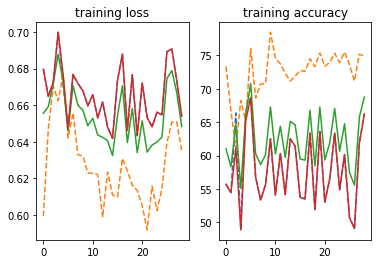

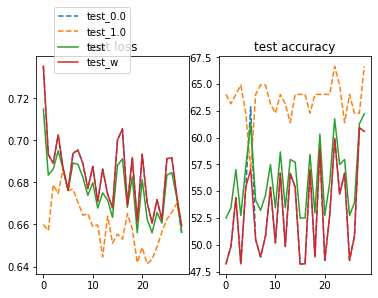

In [33]:
plot_results(loss_gs, acc_gs, loss_log, acc_log)

In [34]:
loss_gs

{'train': {0.0: array([0.67961758, 0.66482192, 0.67241228, 0.69985652, 0.67096108,
         0.64727104, 0.6768117 , 0.67178512, 0.66788453, 0.65961421,
         0.66570371, 0.65305537, 0.6616478 , 0.64799863, 0.64183027,
         0.67348337, 0.6878773 , 0.64629924, 0.67659104, 0.64330149,
         0.67219067, 0.65329993, 0.64811772, 0.65611911, 0.65469623,
         0.68920839, 0.69072479, 0.67337799, 0.65387899]),
  1.0: array([0.59929866, 0.64707863, 0.67028129, 0.66244179, 0.67678136,
         0.64213669, 0.65586382, 0.63286084, 0.6321286 , 0.62295711,
         0.62269747, 0.62201178, 0.59866893, 0.62345147, 0.61090225,
         0.60986561, 0.63078904, 0.62411445, 0.61618841, 0.61332148,
         0.60515583, 0.59176677, 0.61565661, 0.60233939, 0.61427164,
         0.63927972, 0.65068138, 0.65080494, 0.63480508])},
 'test': {0.0: array([0.73527402, 0.69329286, 0.6891737 , 0.70262325, 0.68615931,
         0.67614734, 0.69386828, 0.69535625, 0.68903792, 0.67708033,
         0.68764222, 

# save result logs

In [35]:
from utils.test_utils import save_logs, load_logs

In [36]:
save_logs(save_dir, loss_gs, acc_gs, loss_log, acc_log)

save loss group logs
save accuracy group logs
save average/worst loss logs
save average/worst accuracy logs


# Load logs

In [37]:
loss_gs, acc_gs, loss_log, acc_log = load_logs(save_dir)

load loss group logs
load accuracy group logs
load average/worst loss logs
load average/worst accuracy logs


In [38]:
dl_cum_loaders[it].dataset.tensors[1].numpy().shape

(979, 1)

In [39]:
import numpy as np
np.unique(dl_cum_loaders[it].dataset.tensors[0].numpy(),axis=0).shape

(979, 100)

In [40]:
from utils.data_utils import dataset_description, dl2nparray

data loader 0


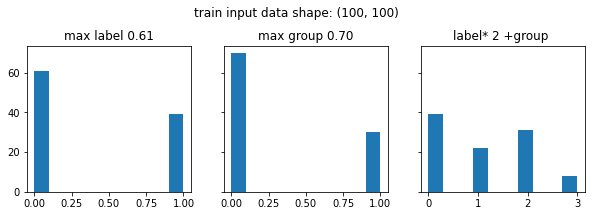

data loader 1
selected group is 0.0


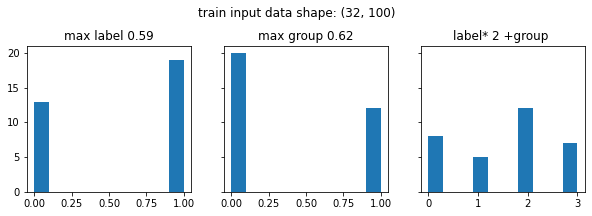

data loader 2
selected group is 0.0


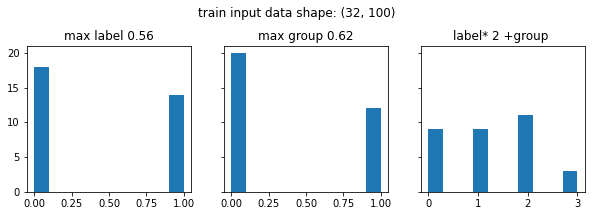

data loader 3
selected group is 1.0


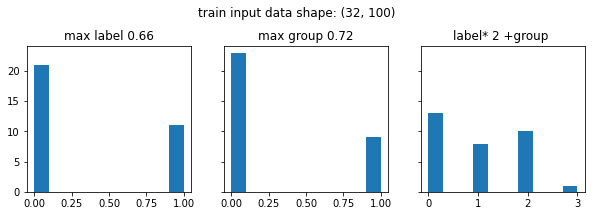

data loader 4
selected group is 0.0


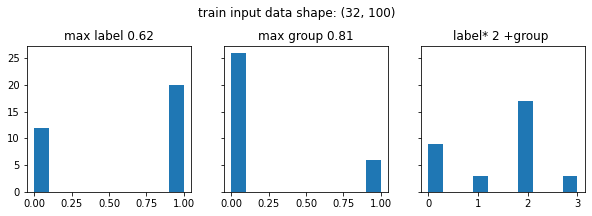

data loader 5
selected group is 1.0


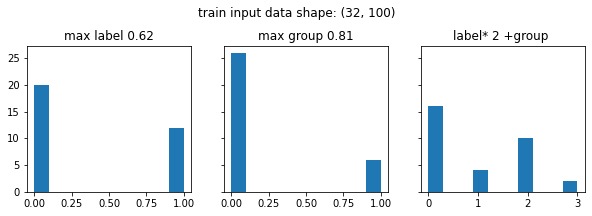

data loader 6
selected group is 0.0


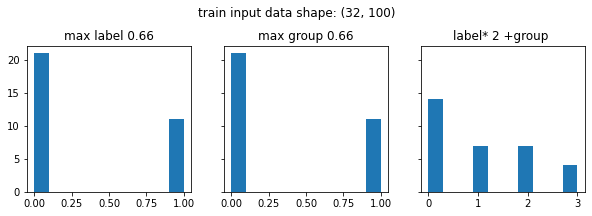

data loader 7
selected group is 1.0


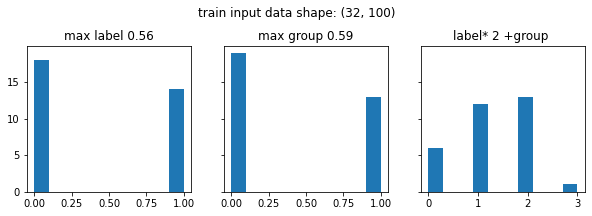

data loader 8
selected group is 1.0


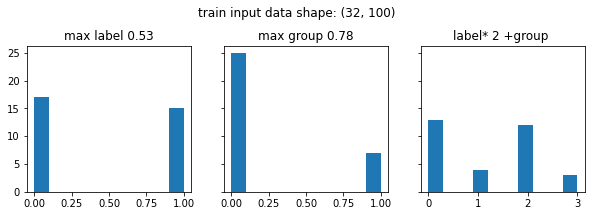

data loader 9
selected group is 0.0


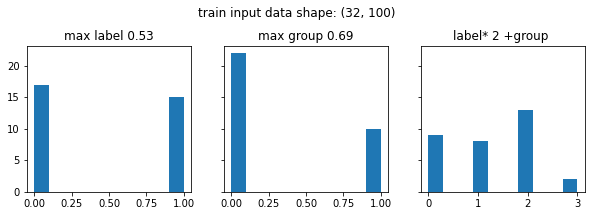

data loader 10
selected group is 1.0


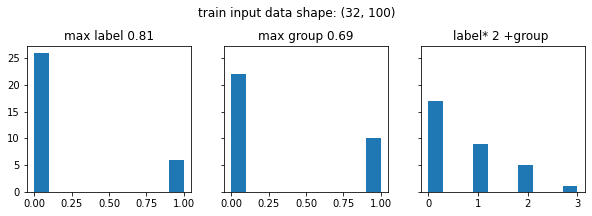

data loader 11
selected group is 0.0


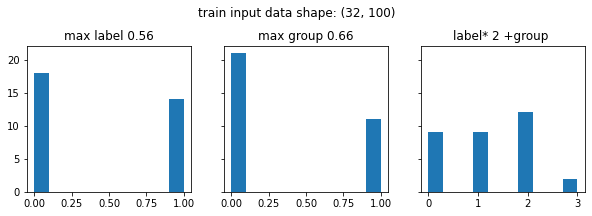

data loader 12
selected group is 0.0


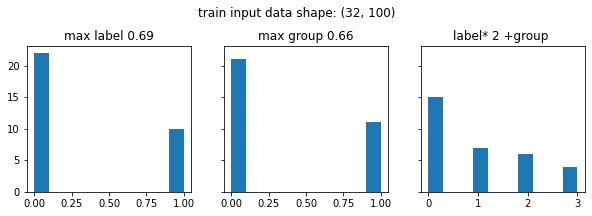

data loader 13
selected group is 0.0


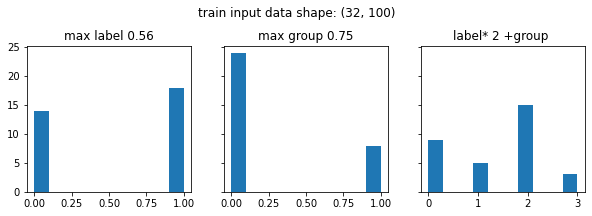

data loader 14
selected group is 1.0


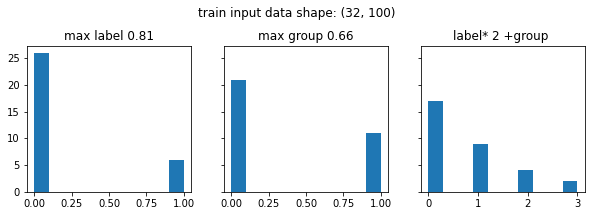

data loader 15
selected group is 1.0


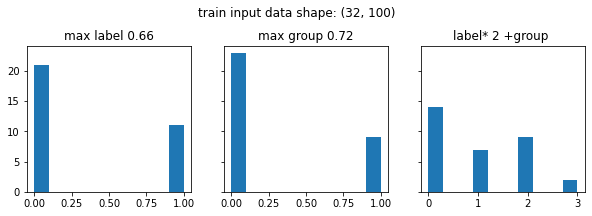

data loader 16
selected group is 0.0


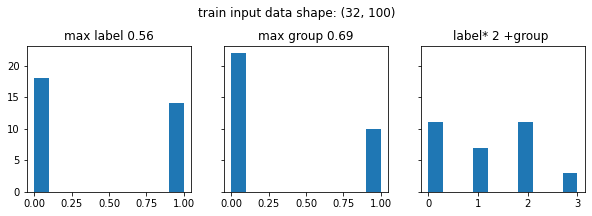

data loader 17
selected group is 0.0


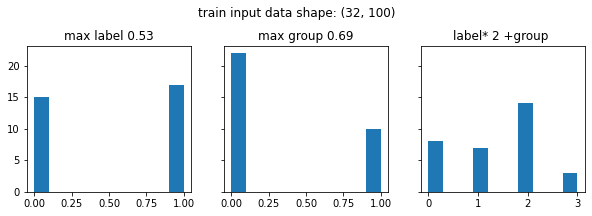

data loader 18
selected group is 1.0


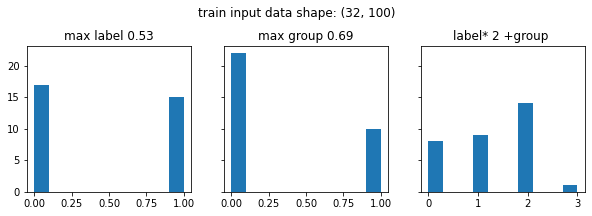

data loader 19
selected group is 0.0


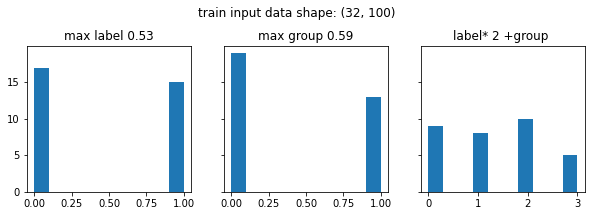

data loader 20
selected group is 1.0


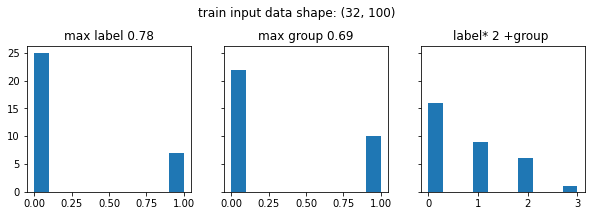

data loader 21
selected group is 0.0


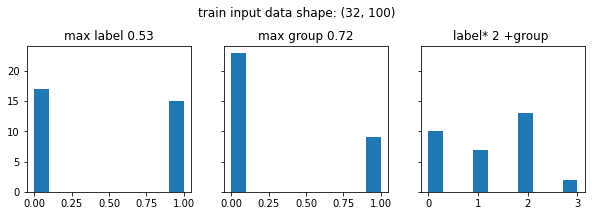

data loader 22
selected group is 0.0


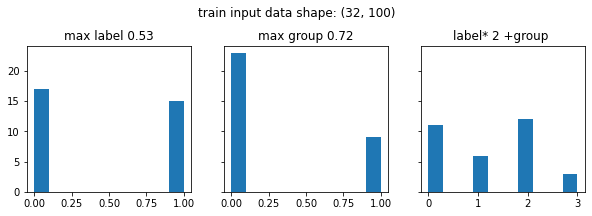

data loader 23
selected group is 1.0


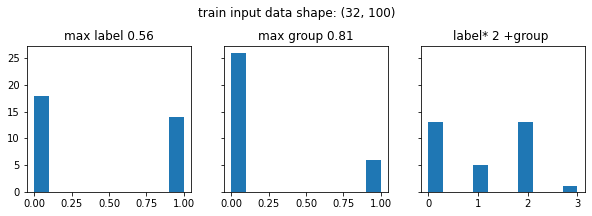

data loader 24
selected group is 0.0


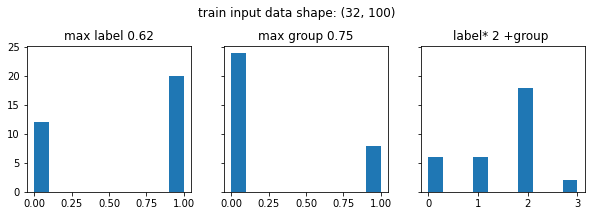

data loader 25
selected group is 0.0


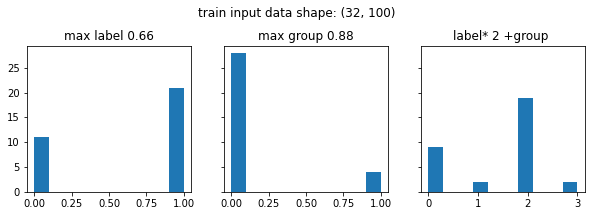

data loader 26
selected group is 0.0


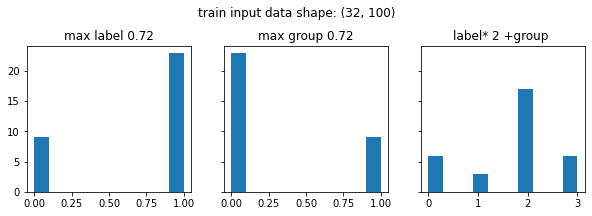

data loader 27
selected group is 0.0


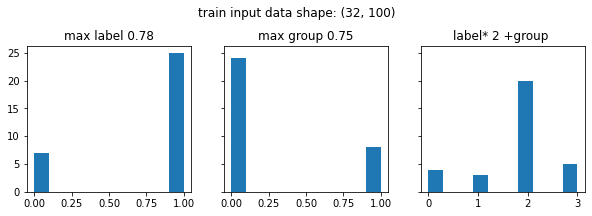

data loader 28
selected group is 1.0


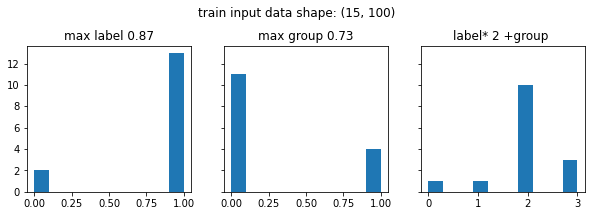

data loader 29
selected group is 1.0


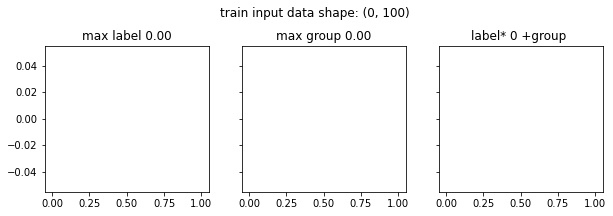

In [41]:
for i in range(len(dl_loaders)):
    print("data loader",i)
    if i>0:
        print("selected group is", gids[i-1])
    x,y,z = dl2nparray(dl_loaders[i])
    dataset_description(x,y,z)

data cumulative loader 0


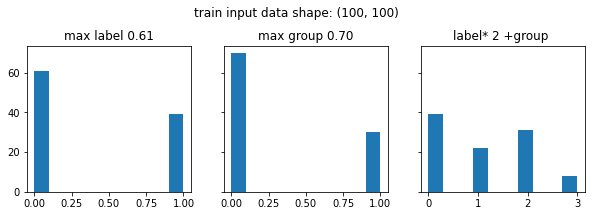

data cumulative loader 1


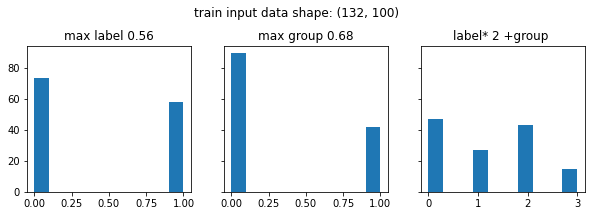

data cumulative loader 2


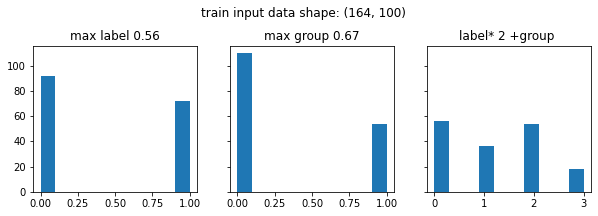

data cumulative loader 3


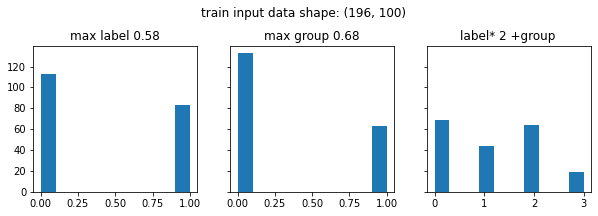

data cumulative loader 4


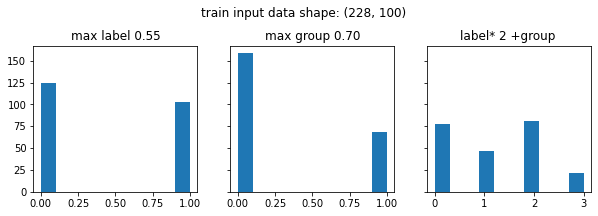

data cumulative loader 5


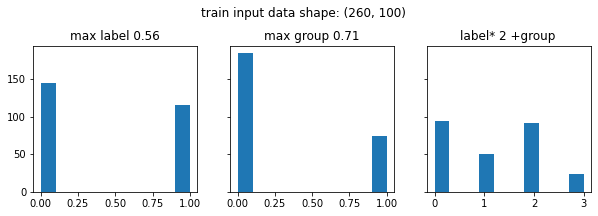

data cumulative loader 6


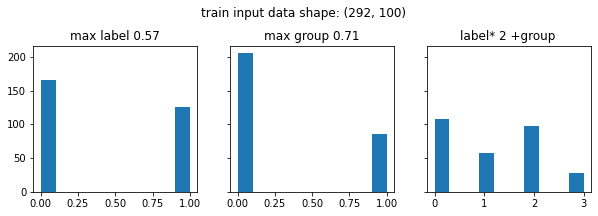

data cumulative loader 7


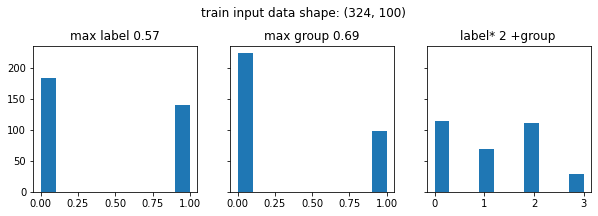

data cumulative loader 8


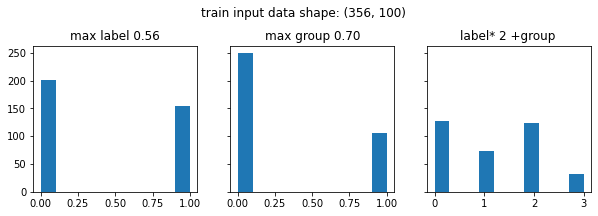

data cumulative loader 9


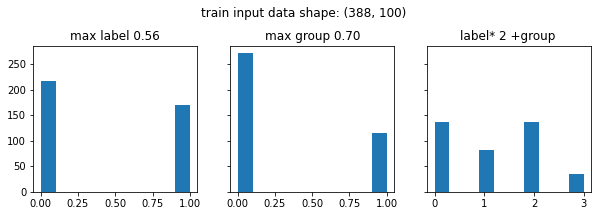

data cumulative loader 10


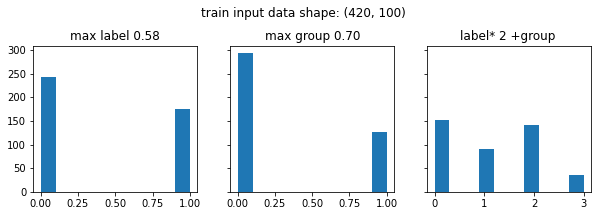

data cumulative loader 11


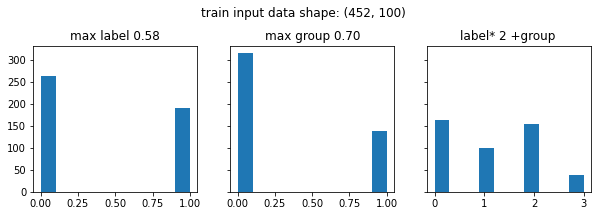

data cumulative loader 12


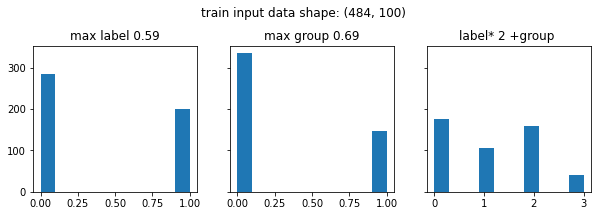

data cumulative loader 13


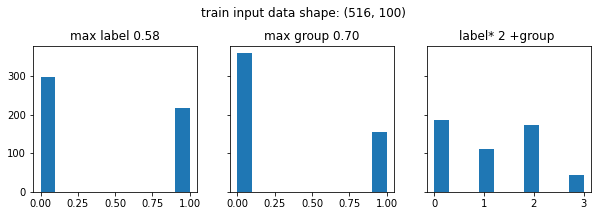

data cumulative loader 14


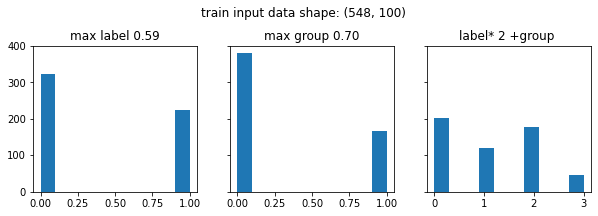

data cumulative loader 15


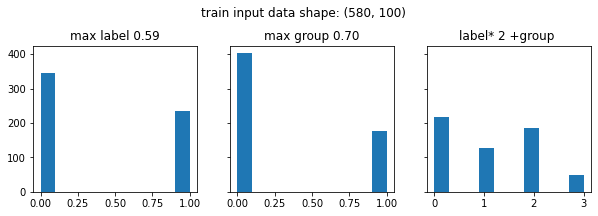

data cumulative loader 16


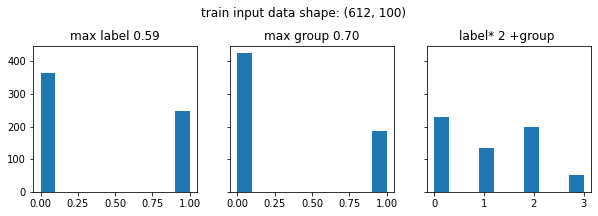

data cumulative loader 17


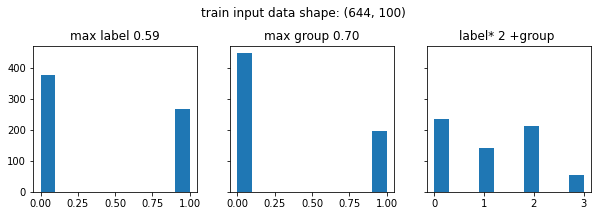

data cumulative loader 18


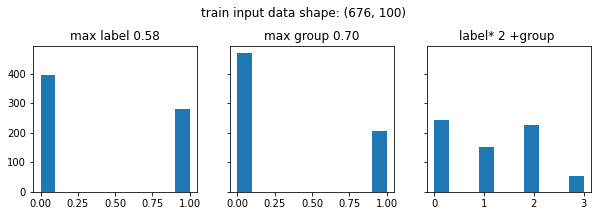

data cumulative loader 19


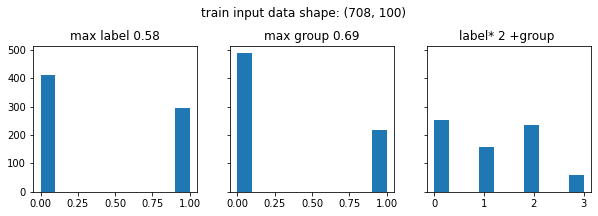

data cumulative loader 20


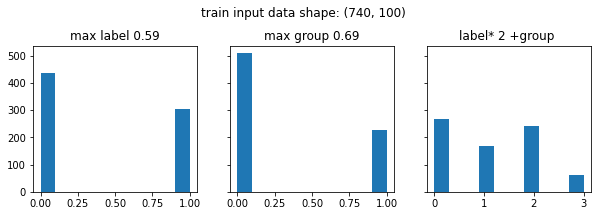

data cumulative loader 21


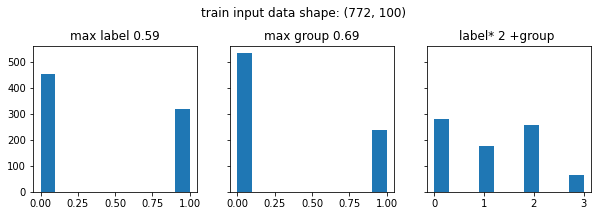

data cumulative loader 22


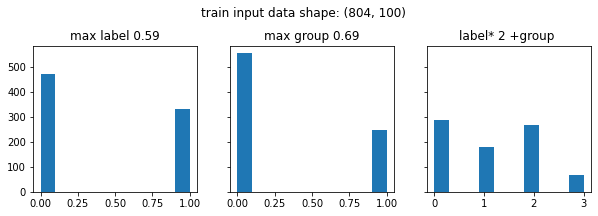

data cumulative loader 23


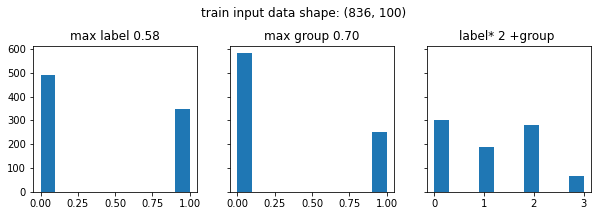

data cumulative loader 24


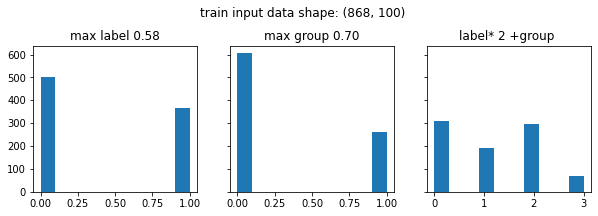

data cumulative loader 25


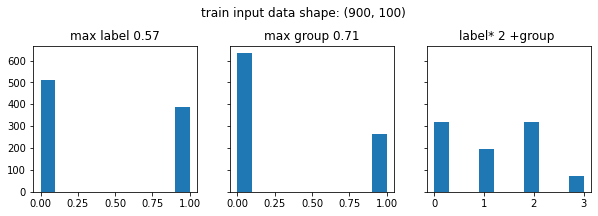

data cumulative loader 26


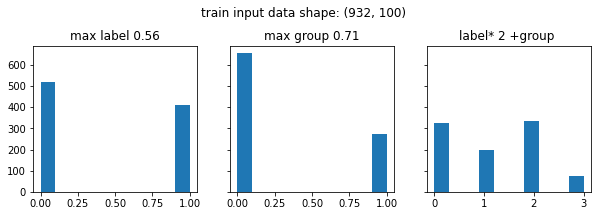

data cumulative loader 27


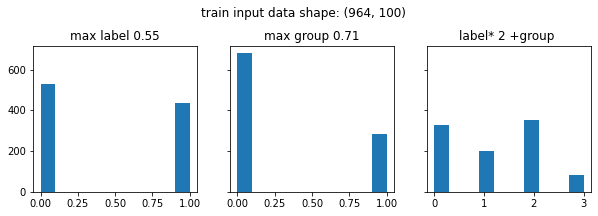

data cumulative loader 28


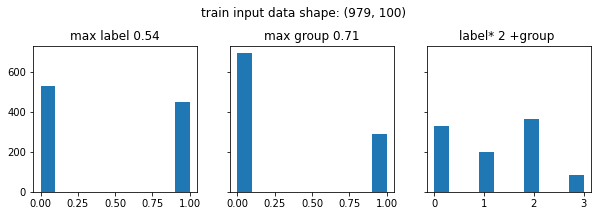

data cumulative loader 29


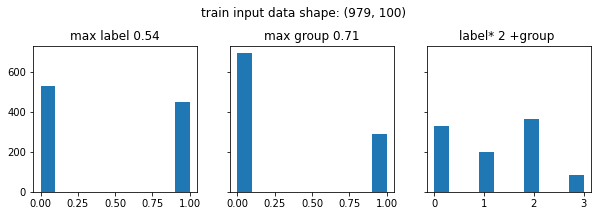

In [42]:
for i in range(len(dl_loaders)):
    print("data cumulative loader",i)
    x,y,z = dl2nparray(dl_cum_loaders[i])
    dataset_description(x,y,z)

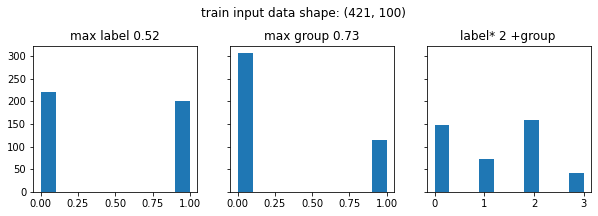

In [43]:
x,y,z = dl2nparray(test_loader)
dataset_description(x,y,z)

In [44]:
dl_loader.dataset.tensors[0].shape

torch.Size([979, 100])